In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import glob

import sys
sys.path.append("../..") # include base dir

from jlonevae_lib.architecture.load_model import load_model
import jlonevae_lib.architecture.vae_jacobian as vj

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-fvwjs70p because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
### COPYPASTA from disentanglement_lib/disentanglement_lib/data/ground_truth/threeDots.py
### EASIER than trying to figure out how to import that file here

# create an image with dots of the given radius (range 0 to 1)
# placed at the given locations (shape: (N, 2)) in the range 0 to 1
# the output image is shape (64, 64, 1)
# with a black dot on a white background
# and some gray colors on the border pixels
# (the gray color is created by making a purely black circle on a 10x larger image
# and then resizing the image smaller and averaging nearby pixels
def draw_dots_to_image_array(radius, dot_centers):
    num_object = dot_centers.shape[0]
    im_side_len = 64
    # in order to get nicely averaged/grayscale shape boundary
    # we draw on a larger canvas and scale down
    # Create a black image
    upscale_image_factor = 10
    precision_scale = 10
    black = 0 
    up_img = np.ones((im_side_len * upscale_image_factor,im_side_len *
      upscale_image_factor,1))
    up_radius = int(im_side_len * radius * upscale_image_factor * 2**precision_scale)
    for i in range(num_object):
        up_center = np.floor(im_side_len * dot_centers[i] * upscale_image_factor * 2**precision_scale).astype(int)
        # negative thickness means filled circle
        circle = cv2.circle(up_img, tuple(up_center), up_radius, color=black, thickness = -1, shift=precision_scale)
    arr = cv2.resize(up_img, (im_side_len,im_side_len), interpolation=cv2.INTER_AREA)
    return arr

# Embed into model

In [3]:
combinedOutputs = "trainedModels"

In [4]:
def get_test_data():
    base_locs = np.random.uniform(size=(3,2))
    test_data = np.array([[draw_dots_to_image_array(0.08, base_locs)]])
    return test_data

In [5]:
device="cuda" if torch.cuda.is_available() else "cpu"
def get_model_and_enc(gammastring, timestamp, test_data):
    matching_model_paths = glob.glob(f"../../{combinedOutputs}/defaultConv_lone_beta4_0000_ica{gammastring}_lat10_batch64_lr0_0001_anneal100000/{timestamp}/representation/cache_batch_no300000")
    #print("using model %s" % matching_model_paths)
    model_path = matching_model_paths[0]

    model = load_model(model_path,device).double();
    encoding, logvar = model.encode(torch.tensor(test_data).double().to(device));
    return model, encoding, logvar, test_data

In [6]:
# note that Jg has shape latent, imageShape...which is transpose
# of what you might expect for a jacobian
# We take the SVD as a way to understand how the jacobian transforms
# the latent space locally
def jacs_svd(Jg, latent_dim = 10):
    np.testing.assert_almost_equal(Jg.shape[0], latent_dim)
    jacobian = Jg.reshape([latent_dim, -1]).transpose()
    u,s,vt = np.linalg.svd(jacobian)
    #print(s, vt)
    return u,s,vt

In [7]:
# contrast adjustment for jacobian
scale = 20
outputdir = "./threeDotsJacobians/"
from pathlib import Path
Path.mkdir(Path(outputdir), exist_ok=True)

In [8]:
import scipy.stats

In [9]:
# Following On Implicit Regularization in β-VAEs
# we compute Nabla^2_gz log p(x; g(z))
# = Nabla^2_gz x log g(z) + (1-x)log(1-g(z))
# = - (g(z)^2 - 2g(z)x - x)/(g(z)^2(1-g(z))^2)
# Note: the result is the diagonal of a square matrix with 
# each side length equal to the number of pixels * channels in the image
# ...shaped in a way to make the correspondence to pixels easily interpretable
def Hpx(x, gz):
    #print(min(gz.flatten()), max(gz.flatten()), min(x.flatten()), max(x.flatten()))
    diff = x - gz
    #print(min(diff), max(diff))
    pixelwiseLogprobs = - (gz**2 - 2*gz*x + x)/(gz**2*(1-gz)**2)
    #print(pixelwiseLogprobs.shape)
    return np.clip(pixelwiseLogprobs, -1e32, 0)

# see equation 11 of that paper
# note that Jg has shape latent, imageShape...which is transpose
# of what you might expect for a jacobian
def optLogCovar(x, gz, Jg, beta):
    xshape = x.shape
    gzshape = gz.shape
    Jgshape = Jg.shape
    #print(f"X {xshape}, gz {gzshape}, Jg {Jgshape}")
    np.testing.assert_almost_equal(xshape, gzshape)
    np.testing.assert_almost_equal(xshape, Jgshape[1:])
    H = Hpx(x, gz)
    plt.imshow(H[0]);plt.colorbar();plt.show();plt.close();
    #print(f"H {H.shape}")
    esum = np.einsum("lchw,chw,kchw->lk",Jg, H, Jg)
    #print(esum)
    denominator = np.eye(Jg.shape[0])-(1/beta)*esum
    #print(denominator)
    s = 1/denominator
    return np.log(s)

In [10]:
gammastring = "0_1000"
timestamp ="*"
#test_data = get_test_data()
base_locs = np.array([[32/64., 16/64.],[48/64,32/64.],[16/64.,48/64.]])
test_data = np.array([[draw_dots_to_image_array(0.08, base_locs)]])
model, encoding, logvar, test_data = get_model_and_enc(gammastring,timestamp,test_data)
recon = model.decode(encoding)
jacs = vj.compute_generator_jacobian_analytic(model, encoding, device=device,
                                    im_channels=1)#.detach().cpu().numpy()
logvar = logvar.detach().cpu().numpy()
recon = recon.detach().cpu().numpy()
emb_jacs = vj.compute_embedding_jacobian_analytic(model, torch.tensor(test_data), device=device)
print(jacs.shape)
print(emb_jacs.shape)

(10, 1, 1, 64, 64)
(10, 1, 64, 64)


In [11]:
recon_ability = np.einsum("labc,ldef->abcdef", jacs[:,0,:,:,:],emb_jacs)
large_succeptibility = recon_ability.reshape((64*64, 64*64))
w,v = np.linalg.eig(large_succeptibility)

In [12]:
w[np.abs(w)>0.001]

array([ 1.06686614+0.j       ,  0.88813872+0.0692842j,
        0.88813872-0.0692842j,  0.78179756+0.j       ,
        0.51268225+0.j       ,  0.44436267+0.j       ,
        0.18921348+0.j       ,  0.12416409+0.j       ,
       -0.02374246+0.j       ,  0.02439764+0.j       ])

In [13]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
gray = (167/255, 168/255, 170/255, 1)
red = (179/255, 27/255, 27/255, 1)
blue = (0,47/255, 108/255,1)
markersize=10

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


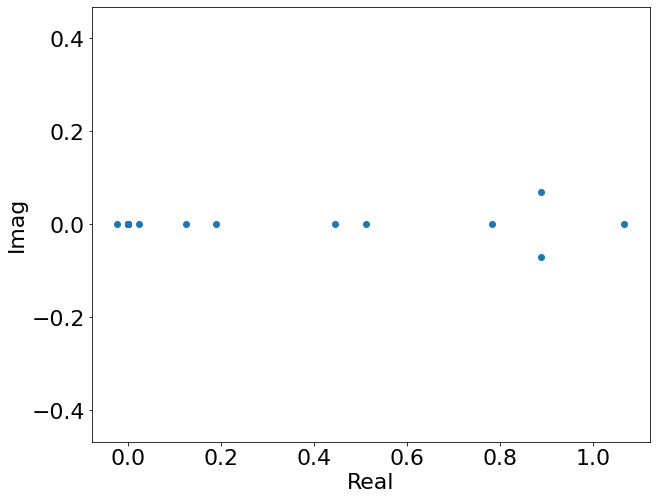

In [14]:
f = plt.figure(figsize=(10,8))
plt.scatter(np.real(w[np.abs(w)>0]), np.imag(w[np.abs(w)>0]))
plt.xlim(-0.25, 1.25)
plt.ylim(-0.7, 0.7)
plt.xlabel("Real")
plt.ylabel("Imag")
plt.axis('equal')
f.savefig("cyclicConsistency/cyclic_consistency_eigenvalues.png")
plt.show();

# Explicitly writing out T

In [15]:
def get_nonzero_eigenvals_vects(w,v):
    orderedInds = np.argsort(-np.abs(w))
    vs = []
    ws = np.zeros((20,20))
    basis_ind = 0
    i = 0
    while i < len(orderedInds):
        indx = orderedInds[i]
        if np.abs(w[indx]) < 0.001:
            break
        if np.max(np.abs(np.imag(v[:,indx]))) < 0.001:
            vs.append(np.real(v[:,indx]))
            ws[basis_ind,basis_ind] = np.real(w[indx])
            basis_ind += 1
            i += 1
        else:
            vs.append(np.real(v[:,indx]))
            vs.append(np.imag(v[:,indx]))
            ws[basis_ind,basis_ind] = np.real(w[indx])
            ws[basis_ind+1,basis_ind+1] = np.real(w[indx])
            ws[basis_ind,basis_ind+1] = np.imag(w[indx])
            ws[basis_ind+1,basis_ind] = -np.imag(w[indx])
            basis_ind += 2
            # complex eigenvalues come in pairs
            i += 2
    ws = ws[:basis_ind, :basis_ind]
    vs = np.array(vs)
    return(ws, vs)

In [16]:
ws, vs = get_nonzero_eigenvals_vects(w,v)
scaling_factor = np.sqrt(np.sum(np.square(vs), axis=1))
scaled_vs = vs/(scaling_factor[:,np.newaxis])
scaled_ws = (scaling_factor[:,np.newaxis]) * ws /scaling_factor[np.newaxis,:]

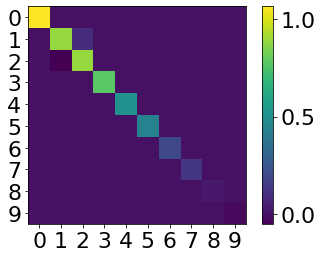

In [17]:
f = plt.figure()
plt.imshow(scaled_ws); 
plt.colorbar();
plt.xticks(range(10))
plt.yticks(range(10))
f.savefig("cyclicConsistency/cyclic_consistency_basis_transform.png")
plt.show();plt.close();

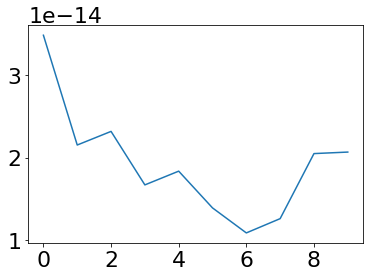

In [18]:
plt.plot(np.sum(np.abs(np.matmul(large_succeptibility, scaled_vs.T) - np.matmul(scaled_vs.T,scaled_ws)),axis=0))

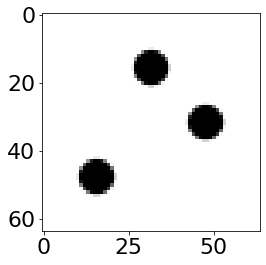

In [19]:
plt.imshow(test_data[0,0], cmap="gray")

In [20]:
np.sum(np.square(scaled_vs),axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

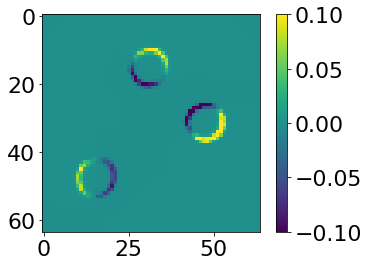

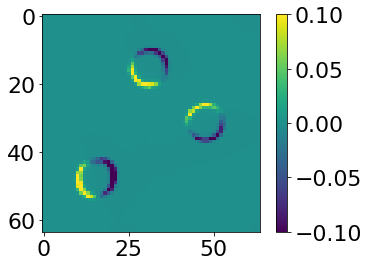

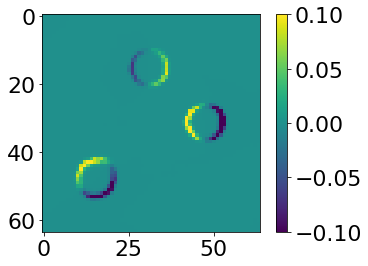

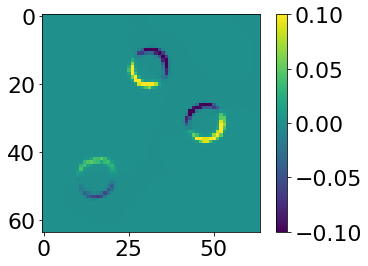

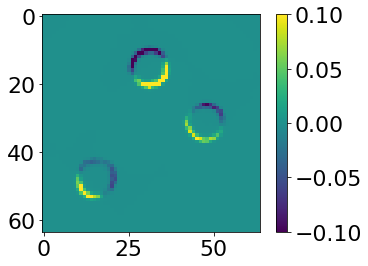

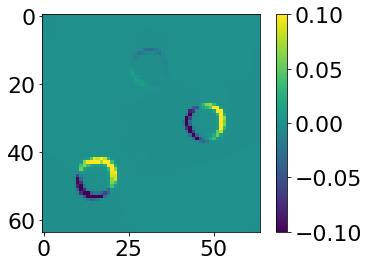

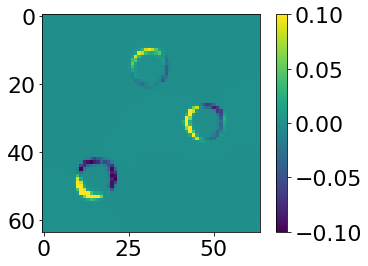

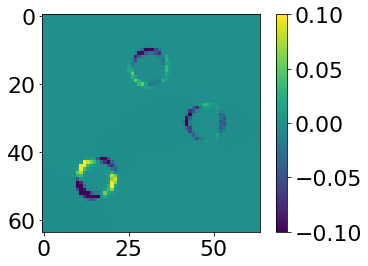

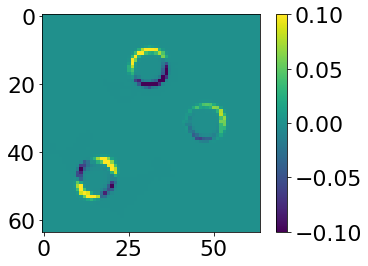

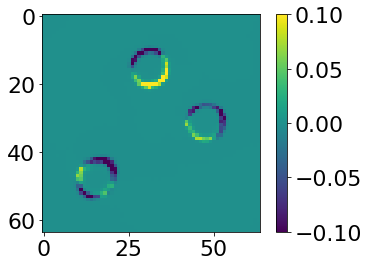

In [21]:
for i in range(10):
    f = plt.figure()
    plt.imshow(scaled_vs[i,:].reshape((64,64)),vmin=-0.1,vmax=0.1);plt.colorbar();plt.show()
    f.savefig(f"cyclicConsistency/cyclic_consistency_basisvect_{i}.png");
    plt.close();

# Other Cycle

In [22]:
other_recon_ability = np.einsum("labc,jabc->lj",emb_jacs, jacs[:,0,:,:,:])
succeptibility = other_recon_ability
o_w,o_v = np.linalg.eig(succeptibility)

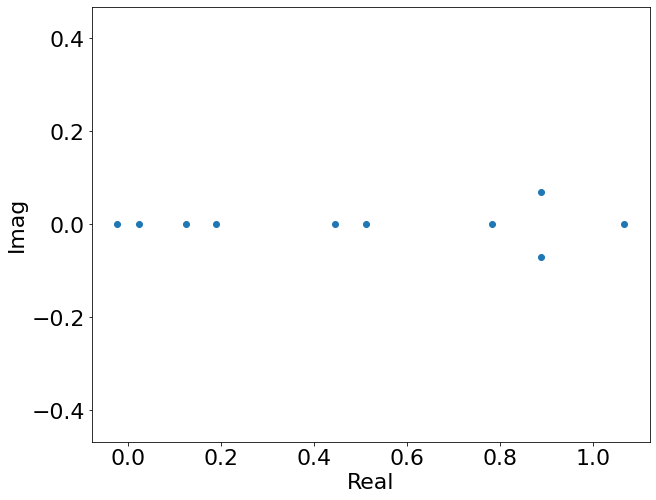

In [23]:
f = plt.figure(figsize=(10,8))
plt.scatter(np.real(o_w[np.abs(o_w)>0]), np.imag(o_w[np.abs(o_w)>0]))
plt.xlim(-0.25, 1.25)
plt.ylim(-0.7, 0.7)
plt.xlabel("Real")
plt.ylabel("Imag")
plt.axis('equal')
f.savefig("cyclicConsistency/other_cyclic_consistency_eigenvalues.png")
plt.show();

In [24]:
ws, vs = get_nonzero_eigenvals_vects(o_w,o_v)
scaling_factor = np.sqrt(np.sum(np.square(vs), axis=1))
scaled_vs = vs/(scaling_factor[:,np.newaxis])
scaled_ws = (scaling_factor[:,np.newaxis]) * ws /scaling_factor[np.newaxis,:]

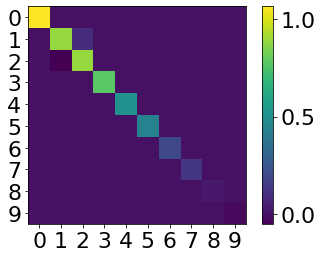

In [25]:
f = plt.figure()
plt.imshow(scaled_ws); 
plt.colorbar();
plt.xticks(range(10))
plt.yticks(range(10))
f.savefig("cyclicConsistency/other_cyclic_consistency_basis_transform.png")
plt.show();plt.close();

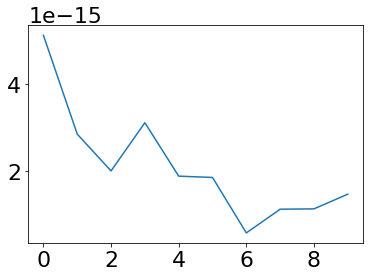

In [26]:
plt.plot(np.sum(np.abs(np.matmul(succeptibility, scaled_vs.T) - np.matmul(scaled_vs.T,scaled_ws)),axis=0))

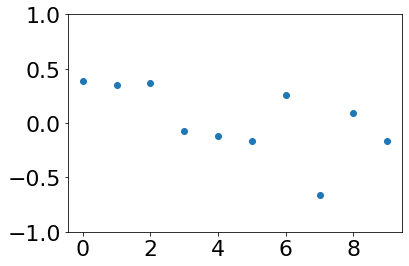

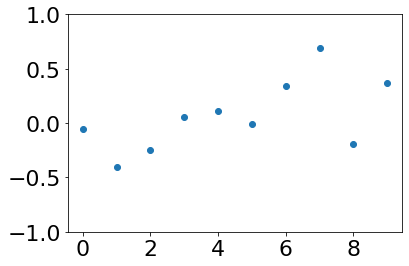

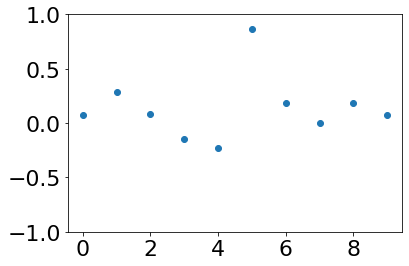

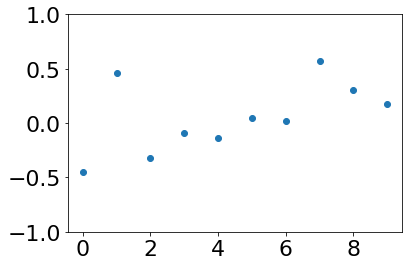

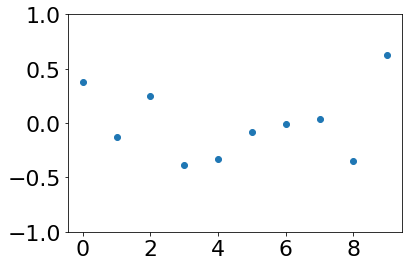

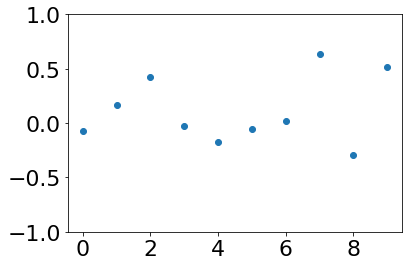

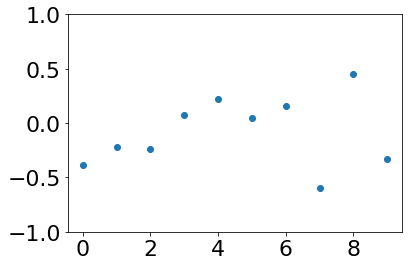

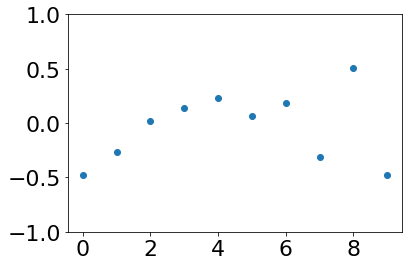

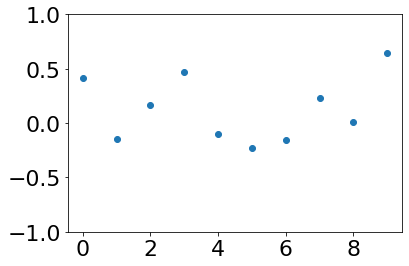

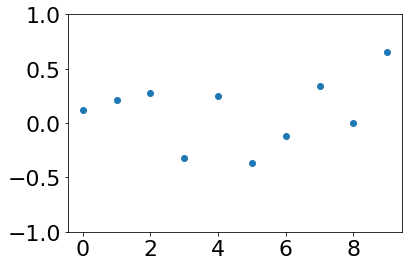

In [27]:
for i in range(10):
    f = plt.figure()
    plt.scatter(range(10), scaled_vs[i,:])
    plt.ylim((-1,1))
    f.savefig(f"cyclicConsistency/other_cyclic_consistency_basisvect_{i}.png");
    plt.show();
    plt.close();

# Scratchwork

0_1000
0_1000
0_1000
0_1000


/home/tsr42/anaconda3/envs/jlonevae/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


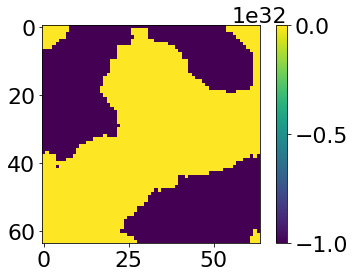

/home/tsr42/anaconda3/envs/jlonevae/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log


[-4.96412973 -5.83729266 -4.70217038 -5.31009696 -6.18558461 -5.52749179
 -6.18484043 -4.26691354 -5.48123027 -3.80919279]
[[-5.96169096 -6.06488987 -5.27033874 -5.11769086 -6.24010289 -5.91363473
  -6.21127464 -4.92135782 -5.82316008 -4.64556008]]


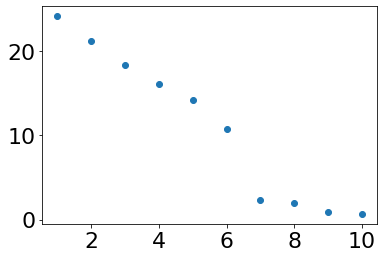

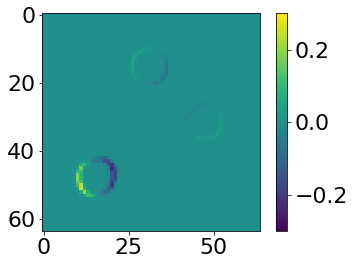

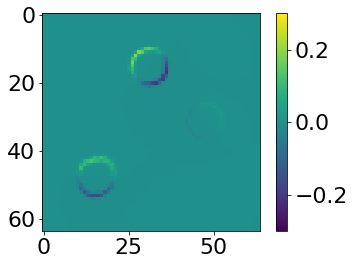

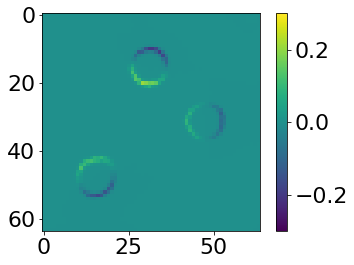

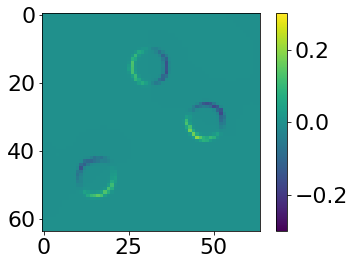

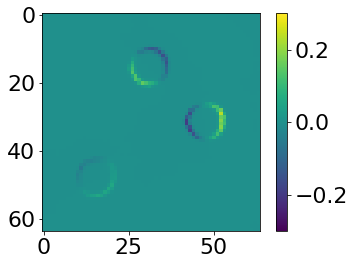

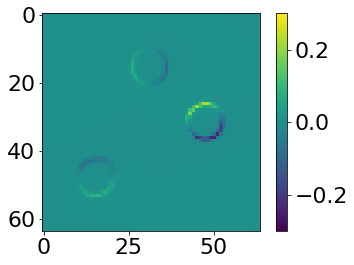

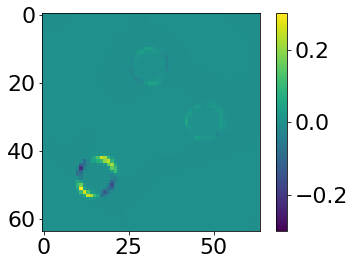

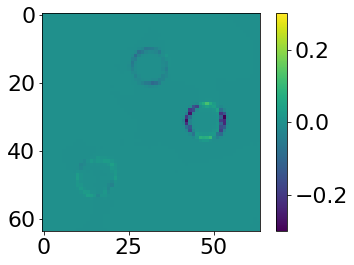

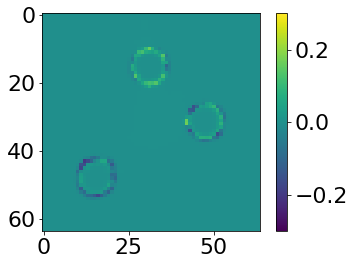

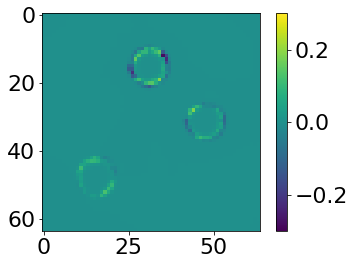

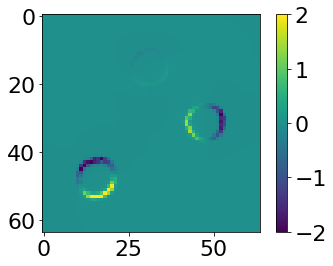

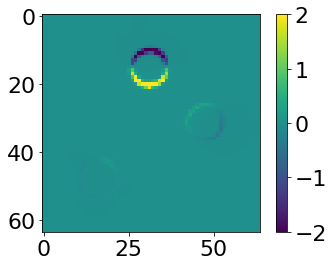

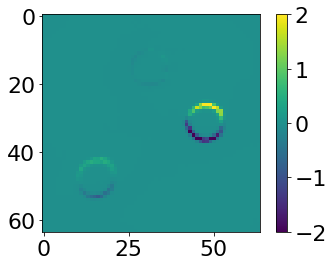

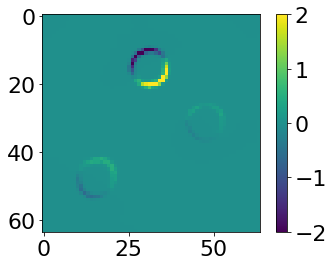

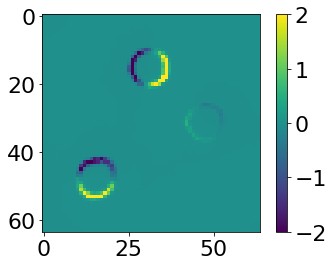

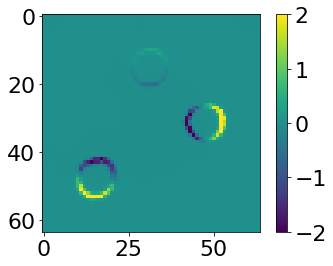

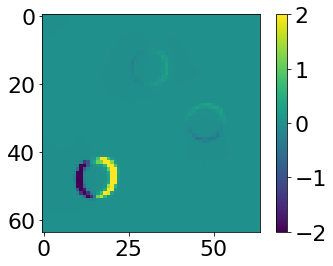

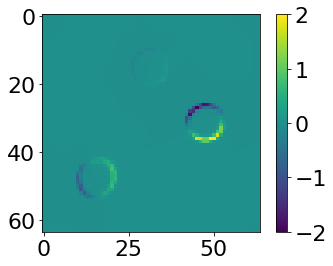

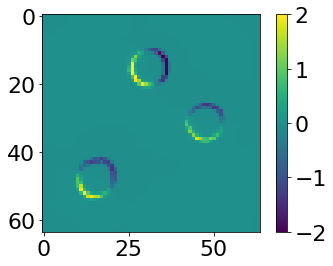

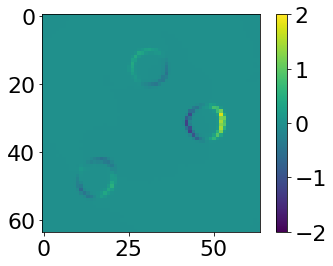

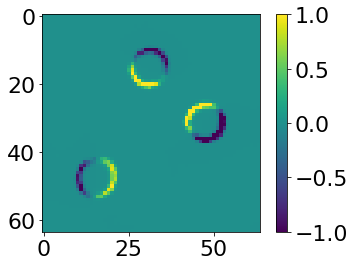

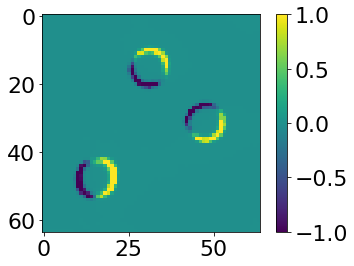

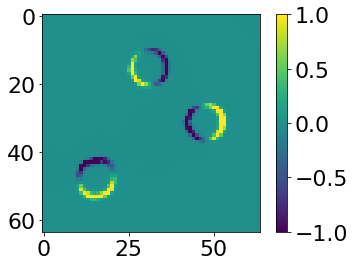

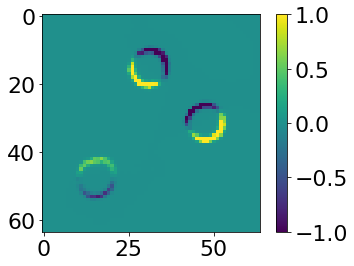

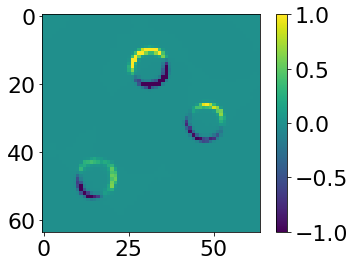

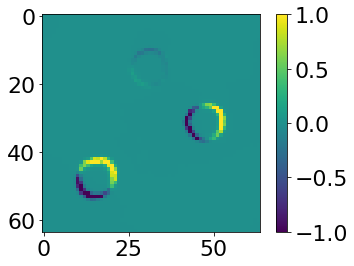

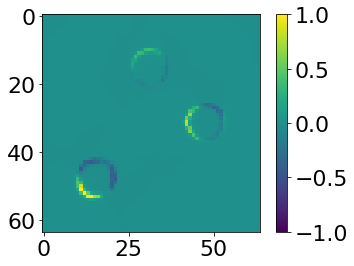

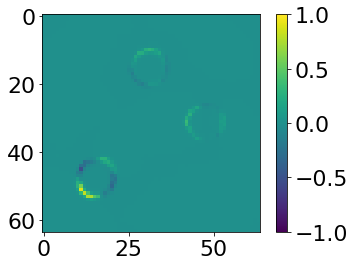

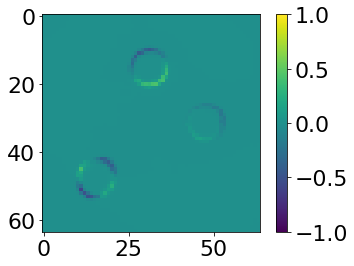

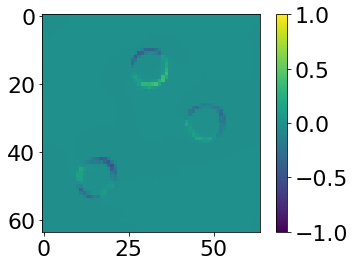

In [35]:
# either switch these timestamps to * (to find any matchign run)
# or update to a particular run. These timestamps are associated with the models used in the paper
for gammastring, timestamp in [("0_1000","*")]:
    print(gammastring)
    print(gammastring)
    print(gammastring)
    print(gammastring)
    model, encoding, logvar, test_data = get_model_and_enc(gammastring,timestamp,test_data)
    recon = model.decode(encoding)
    jacs = vj.compute_generator_jacobian_analytic(model, encoding, device=device,
                                        im_channels=1)#.detach().cpu().numpy()
    jacs_svd(jacs)
    logvar = logvar.detach().cpu().numpy()
    recon = recon.detach().cpu().numpy()
    emb_jacs = vj.compute_embedding_jacobian_analytic(model, torch.tensor(test_data), device=device)
    # everything has a fake "batch" index...
    estLogCovar = optLogCovar(test_data[0], recon[0], jacs[:,0,:,:,:], beta=4)
    print(np.diag(estLogCovar))
    print(logvar)
    u,s,vt = jacs_svd(jacs)
    plt.scatter(range(1,len(s)+1),s);plt.show();plt.close();
    for i in range(10):
        f = plt.figure();
        plt.imshow(u[:,i].reshape((64,64)), vmin=-0.3, vmax=0.3);plt.colorbar();
        f.savefig(f"cyclicConsistency/generative_singular_vector_{i}.png");
        plt.show();plt.close();
    for i in range(10):
        f = plt.figure();
        plt.imshow(jacs[i,0,0], vmin=-2.0, vmax=2.0);plt.colorbar();
        f.savefig(f"cyclicConsistency/generative_jacobian_vector_{i}.png");
        plt.show();plt.close();
        
    gen_delta = np.einsum("lhw,il->ihw",jacs[:,0,0,:,:],scaled_vs).reshape((10,64,64));
    for i in range(10):
        f = plt.figure();
        plt.imshow(gen_delta[i],vmin=-1,vmax=1);
        plt.colorbar();
        f.savefig(f"cyclicConsistency/other_cyclic_half_cycle_{i}.png");
        plt.show();plt.close();

In [ ]:
A = np.random.uniform(size=(600,600))
u, s, vt = np.linalg.svd(A)
evals, evects = np.linalg.eig(A)

In [ ]:
s

In [ ]:
evals